# <span style="color:red">To get this notebook working  all 'Mini_SPICE/' need to removed from paths and also module imports with 'Mini_SPICE' need to be removed as well.</span>

This notebook was previously in /home/hpc/iwal/iwal132h/ location

In [6]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay
import pandas as pd

import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile

from base64 import b64decode

import music21
from pydub import AudioSegment

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print("tensorflow: %s" % tf.__version__)
#print("librosa: %s" % librosa.__version__)

2023-10-09 19:42:12.713752: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 19:42:12.753707: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 19:42:12.755174: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 19:42:16.460690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensorflow: 2.12.0


# Load Data SPICE

## Load from Scratch

In [ ]:
from Mini_SPICE.data_files.dataloader import MedleyDBLoader, MIR1KLoader

In [ ]:
mdb_loader = MedleyDBLoader(fs=16000, audio_loc="Mini_SPICE/datasets/MedleyDB/Audio", f0_loc="Mini_SPICE/datasets/MedleyDB/Pitch_Annotations", annot_hop=256, orig_fs=44100)
mir_loader = MIR1KLoader(fs=16000, audio_loc="Mini_SPICE/datasets/MIR-1K/Wavfile", f0_loc="Mini_SPICE/datasets/MIR-1K/PitchLabel",voiced_loc="Mini_SPICE/datasets/MIR-1K/vocal-nonvocalLabel", annot_hop=320, orig_fs=16000)

In [ ]:
# MDB_id_list = mdb_loader.get_ids()
MDB_id_list = mdb_loader.get_ids()

# load audio
songs = []
f0_list = []
foo = []
for i, s in enumerate(MDB_id_list):
    try:
        song, f0 = mdb_loader.load_data(s)
        # print(song.shape, f0.shape)
        # convert stereo to mono
        songs.append(librosa.to_mono(song))
        f0_list.append(f0)
        foo = np.concatenate((foo, f0[2]), axis=0)
    except AssertionError as e:
        print("Cannot load song {} because {}".format(s, e))

Cannot load song HezekiahJones_BorrowedHeart_STEM_10 because The item cannot be loaded due to an annotation length mismatch.


In [ ]:
songs_np = np.array(songs)

/tmp/ipykernel_711636/3440550660.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  songs_np = np.array(songs)


In [ ]:
# import pandas as pd
# df = pd.DataFrame(f0_list, columns=["Time", "Voicing", "Label"])
Time = []
Voicing = []
Label = []
for f in f0_list:
    Time.append(f[0])
    Voicing.append(f[1])
    Label.append(f[2])
Time = np.array(Time)
Voicing = np.array(Voicing)
Label = np.array(Label)    

/tmp/ipykernel_711636/483349314.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Time = np.array(Time)
/tmp/ipykernel_711636/483349314.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Voicing = np.array(Voicing)
/tmp/ipykernel_711636/483349314.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Label = np.array(Label)


In [ ]:
data_mdb = np.vstack((np.array(songs), Time,Voicing,Label))

/tmp/ipykernel_711636/3678673902.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_mdb = np.vstack((np.array(songs), Time,Voicing,Label))


In [ ]:
mdb_df = pd.DataFrame(data_mdb.T)
mdb_df.to_pickle('Mini_SPICE/data_test/MedleyDB_audio.pkl')

## Load from Dataframe (Use This)

In [3]:
mir_df_read = pd.read_pickle('data_test/MIR_audio.pkl')
mdb_df_read = pd.read_pickle('data_test/MedleyDB_audio.pkl')

In [4]:
mir_songs = mir_df_read.iloc[:,:1].to_numpy().reshape(1000,)
mir_f0_list = mir_df_read.iloc[:,1:4].to_numpy().reshape(1000,3)

In [5]:
mdb_songs = mdb_df_read.iloc[:,:1].to_numpy().reshape(64,)
mdb_f0_list = mdb_df_read.iloc[:,1:4].to_numpy().reshape(64,3)

## Load Datagen

### From datagen

In [1]:
from Mini_SPICE.data_files.dataloader import DatagenLoader

In [2]:
datagen_loader = DatagenLoader(fs=16000, audio_loc="Mini_SPICE/datasets/latest/wavfile", f0_loc="Mini_SPICE/datasets/latest/labels", annot_hop=256, orig_fs=44100)

In [ ]:
datagen_ids = datagen_loader.get_ids()

In [4]:
# x, f = datagen_loader.load_data('latest_40')

In [ ]:

# load audio
songs = []
f0_list = []
for i, s in enumerate(datagen_ids):
    try:
        song, f0 = datagen_loader.load_data(s)
        # print(song.shape, f0.shape)
        # convert stereo to mono
        # songs.append(librosa.to_mono(song))
        songs.append(song)
        f0_list.append(f0)
        # foo = np.concatenate((foo, f0[2]), axis=0)
    except AssertionError as e:
        print("Cannot load song {} because {}".format(s, e))

602 602
602 602
1003 1003
1003 1003
337 337
602 602
446 446
337 337
337 337
1003 1003
602 602
1003 1003
337 337
845 845
673 673
602 602
845 845
337 337
673 673
673 673
673 673
673 673
1003 1003
673 673
1003 1003
1003 1003
510 510
1003 1003
845 845
337 337
602 602
845 845
510 510
602 602
337 337
673 673
845 845
845 845
337 337
845 845
673 673
673 673
1003 1003
673 673
510 510
845 845
523 523
1003 1003
510 510
337 337
673 673
845 845
337 337
1003 1003
510 510
510 510
673 673
845 845
1003 1003
510 510
242 242
1003 1003
602 602
510 510
845 845
602 602
1003 1003
337 337
337 337
510 510
673 673
1003 1003
673 673
602 602
602 602
337 337
602 602
602 602
510 510
673 673
337 337
358 358
337 337
845 845
510 510
602 602
512 512
1003 1003
510 510
510 510
510 510
510 510
300 300
510 510
510 510
337 337
602 602
337 337
510 510
845 845


In [ ]:
songs_datagen = [song.reshape(len(song[0]),) for song in songs]
# f0_list_datagen = [f0.T for f0 in f0_list]

### From Cal (Includes pitch head vs freq plots)

In [1]:
import math
import random
import numpy as np
from IPython.display import Audio
def pick_semitone_freq(low, high):
    semitone_ratio = 2 ** (1/12)
    semitone_freq_list = []
    
    current_freq = low
    while current_freq <= high:
        semitone_freq_list.append(current_freq)
        current_freq *= semitone_ratio
    
    return random.choice(semitone_freq_list)

# pick_semitone_freq(110, 440)

def generate_harmonic_wave(fundamental_freq, sampling_rate=16000, N=11, H=512):
    amplitude_f0 = np.random.normal(0, 1)
    t = np.linspace(0, (N*H) / sampling_rate, (N*H), endpoint=False)
    fundamental_signal = amplitude_f0*np.sin(2 * np.pi * fundamental_freq * t)
    harmonic_signal = fundamental_signal.copy()
    

    for i in range(2, 4):  
        frequency = fundamental_freq * i
        random_phase = random.uniform(0, 2 * math.pi)
        harmonic_signal += random.uniform(0, 1) * np.sin(2 * np.pi * frequency * t+random_phase)

    return harmonic_signal

class Generator():
    def __init__(self,M,low=110,high=440):
        self.M = M
        self.low = low
        self.high = high
        
    def generate(self):
        samples = []
        labels = []
        for i in range(self.M):
            f0 = pick_semitone_freq(self.low,self.high)
            wave = generate_harmonic_wave(f0)
            samples.append(wave)
            labels.append(f0)
        
        return np.array(samples), np.array(labels)

In [2]:
import pandas as pd
genrator = Generator(1000,20,2000)
wave, f0 = genrator.generate()

In [27]:
import librosa
print("******* Generating CQT Samples *******\n")
Cqtt = np.zeros((1, 190))
F0 = np.zeros(1)
for s, f in zip(wave, f0):
    C = np.abs(librosa.cqt(s, sr=16000, hop_length=512, 
                fmin= librosa.note_to_hz('C1'),
                n_bins=190, bins_per_octave=24))
    Cqtt = np.vstack((Cqtt, C.T))
    f0 = np.repeat(f, C.shape[1])
    F0 = np.concatenate((F0, f0))
Cqtt = Cqtt[1:, :]
F0 = F0[1:].reshape(-1, 1)
data = np.hstack((Cqtt, F0))
print("******* Generating CQT Samples Completed *******\n")

******* Generating CQT Samples *******

******* Generating CQT Samples Completed *******



In [28]:
### FOR Mini-SPICE
import mir_eval
from tqdm import tqdm
pitch_h = np.array([])
labels= np.array([])
for row in tqdm(data):
    pitch_h1,conf_h1,x_hat1 = model(torch.from_numpy(row[0:128].reshape(1,128)).float())
    pitch_h = np.append(pitch_h, np.array(pitch_h1.detach().numpy()))
    labels = np.append(labels, np.array(row[-1]))

100%|██████████| 12000/12000 [00:54<00:00, 221.46it/s]


In [9]:
### For SPICE

pitch_h = np.array([])
dataset_pitch_output= np.array([])
labels= np.array([])
dataset_voice_original=dataset_voice_pred= np.array([1]*12000)
for s,f in zip(wave, f0):
    model_output = model_hub.signatures["serving_default"](tf.constant(list(s), tf.float32))["pitch"]
    pitch_outputs = [ float(x) for x in model_output]
    pitch_h = np.append(pitch_h, np.array(pitch_outputs))
    pitch_outputs_hz = [output2hz(x) for x in pitch_outputs]
    label = [f] * 12
    dataset_pitch_output = np.append(dataset_pitch_output, np.array(pitch_outputs_hz))
    labels = np.append(labels, np.array(label))
    
    # print(pitch_outputs)
    


In [11]:
pitch_h

array([0.1244099 , 0.02902767, 0.02656386, ..., 0.73676836, 0.73653406,
       0.74009955])

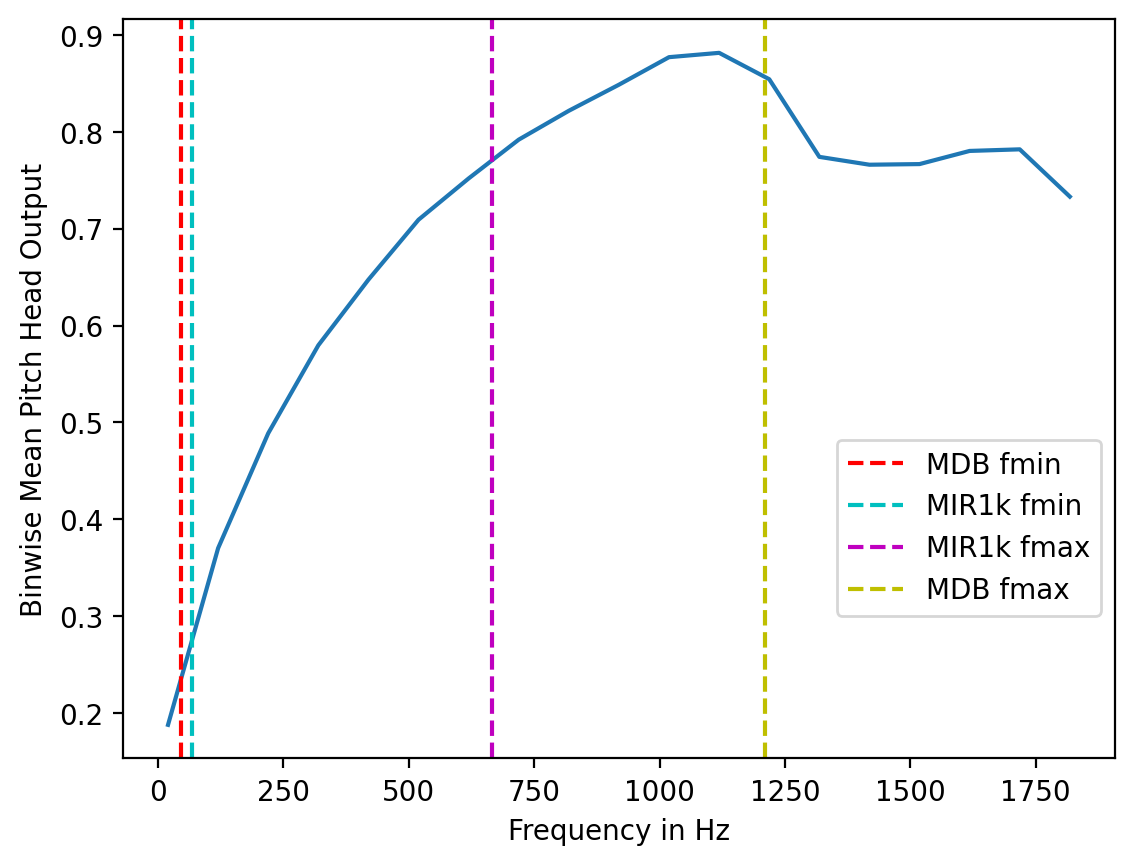

In [12]:
# plt.plot(labels,pitch_h)
from scipy import stats
from matplotlib import pyplot as plt
x = labels
y = pitch_h
bins = np.linspace(min(x), max(x), num=20) 
bin_means, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='mean', bins=bins)
# plt.axvline(x=0.22058956)
plt.plot(bin_edges[:-1], bin_means)
# fig, ax = plt.subplots()
plt.axvline(x=46.259328, color='r', linestyle='--', label='MDB fmin')
# ax.axvline(x=46.259328, color='r', linestyle='--', label='Vertical Line at x=0.5')
# plt.text(46.259328,0,'blah',rotation=90)
plt.axvline(x=66.9456331525636256, color='c', linestyle='--', label='MIR1k fmin')
plt.axvline(x=666.664939769901, color='m', linestyle='--', label='MIR1k fmax')
plt.axvline(x=1210.180328, color='y', linestyle='--', label='MDB fmax')
plt.xlabel('Frequency in Hz')
plt.ylabel('Binwise Mean Pitch Head Output')
# plt.title('Frequency Vs. SPICE Pitch Head Output')
plt.legend(bbox_to_anchor=(1.0, 0.45))

plt.show()

# Own Model

In [25]:
import pandas as pd
from torch.utils.data import DataLoader
from Mini_SPICE.data_files.dataset import CQT_Dataset_test
import torch
from Mini_SPICE.utils.model import Spice_model
import numpy as np
from Mini_SPICE.utils.calibration import Calibrator
model = Spice_model([1, 64, 128, 256, 512, 512, 512], [512, 512, 512, 256, 128, 64, 1], [True, True, True, True, True, True])
checkpoint = torch.load('Mini_SPICE/rev_1k_checkpoints/MIR_minispice.ckp', 'cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# Load Hub Model - SPICE

## Exeute this to get SPICE prediction

In [4]:
%env http_proxy=http://proxy:80
%env https_proxy=http://proxy:80

env: http_proxy=http://proxy:80
env: https_proxy=http://proxy:80


In [ ]:
# Loading the SPICE model is easy:
model_hub = hub.load("https://tfhub.dev/google/spice/2")

In [8]:
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)
def step_func(n, threshold=0.5):
    if n < threshold:
        return 0.
    if n >= threshold:
        return 1.
    
applyall = np.vectorize(step_func)

In [16]:
import scipy 
from tqdm import tqdm

def get_SPICE_pred(songs, f0_list, model):
    MAX_ABS_INT16 = 32768.0
    dataset_pitch_head_output = np.array([])
    dataset_pitch_output = np.array([])
    dataset_voice_original = np.array([])
    dataset_voice_pred = np.array([])
    labels =  np.array([])

    for s, f in tqdm(zip(songs, f0_list)):
        s = s / float(MAX_ABS_INT16)
        model_output = model.signatures["serving_default"](tf.constant(list(s), tf.float32))
        pitch_outputs = model_output["pitch"]
        uncertainty_outputs = model_output["uncertainty"]
        confidence_outputs = 1.0 - uncertainty_outputs
        # confidence_outputs = applyall(confidence_outputs)
        confidence_outputs = list(confidence_outputs)

        dataset_voice_pred = np.append(dataset_voice_pred, applyall(np.array(confidence_outputs)))
        pitch_outputs = [ float(x) for x in pitch_outputs]
        indices = range(len (pitch_outputs))
        dataset_pitch_head_output = np.append(dataset_pitch_head_output,np.array(pitch_outputs))
        pitch_outputs_and_rests = [output2hz(p) for i, p, c in 
                                   zip(indices, pitch_outputs, confidence_outputs)]
        dataset_pitch_output = np.append(dataset_pitch_output,np.array(pitch_outputs_and_rests))

        inter_f = scipy.interpolate.interp1d(x=f[0], y=f[2], axis=0, fill_value="extrapolate")
        t_pred_f = np.arange(0, len(pitch_outputs_and_rests), 1)*512/16000
        f_interpolated = inter_f(t_pred_f)
        labels = np.append(labels,f_interpolated)

        inter_voice = scipy.interpolate.interp1d(x=f[0], y=f[1], axis=0, fill_value="extrapolate")
        t_pred_v = np.arange(0, len(confidence_outputs), 1)*512/16000
        voicing_interpolated = inter_voice(t_pred_v)

        voicing_interpolated = applyall(voicing_interpolated)
        dataset_voice_original = np.append(dataset_voice_original, voicing_interpolated)
    
    assert dataset_pitch_head_output.shape==dataset_pitch_output.shape==dataset_voice_original.shape==dataset_voice_pred.shape==labels.shape, "All arrays must be same shape"
        
    return dataset_pitch_head_output, dataset_pitch_output, dataset_voice_original, dataset_voice_pred, labels
    
    

In [17]:
pitch_outputs, dataset_pitch_output, dataset_voice_original, dataset_voice_pred, labels = get_SPICE_pred(mir_songs, mir_f0_list, model_hub)

1000it [06:50,  2.44it/s]


In [ ]:
# execute this if datagen is ised
def get_SPICE_pred_datagen(songs, f0_list):
    MAX_ABS_INT16 = 32768.0
    dataset_pitch_head_output = np.array([])
    dataset_pitch_output = np.array([])
    dataset_voice_original = np.array([])
    dataset_voice_pred = np.array([])
    labels =  np.array([])

    for s, f in tqdm(zip(songs, f0_list)):
        print(f.shape)

In [ ]:
# get_SPICE_pred_datagen(mir_songs, mir_f0_list)
get_SPICE_pred_datagen(songs, f0_list)

0it [00:00, ?it/s]


## Jump to RPA

# On one item (Skip)

In [ ]:
model_output = model.signatures["serving_default"](tf.constant(single_ch_audio, tf.float32))
pitch_outputs = model_output["pitch"]
uncertainty_outputs = model_output["uncertainty"]
# 'Uncertainty' basically means the inverse of confidence.
confidence_outputs = 1.0 - uncertainty_outputs

2023-09-14 13:14:56.139214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8903
2023-09-14 13:14:56.642674: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [ ]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]
indices = range(len (pitch_outputs))
confident_pitch_outputs = [ (i,p)  
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.9  ]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)

In [ ]:
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)
    
confident_pitch_values_hz = [ output2hz(p) for p in confident_pitch_outputs_y ]

In [ ]:
pitch_outputs_and_rests = [
    output2hz(p) if c >= 0.9 else 0
    for i, p, c in zip(indices, pitch_outputs, confidence_outputs)
]

In [ ]:
len(pitch_outputs_and_rests), f0.shape

(5358, (3, 29534))

In [ ]:
import scipy 
inter_f0 = scipy.interpolate.interp1d(x=f0[0], y=f0[2], axis=0, fill_value="extrapolate")
t_pred = np.arange(0, len(pitch_outputs_and_rests), 1)*512/16000
f0_interpolated = inter_f0(t_pred)

inter_voice = scipy.interpolate.interp1d(x=f0[0], y=f0[1], axis=0, fill_value="extrapolate")
t_pred = np.arange(0, len(pitch_outputs_and_rests), 1)*512/16000
voicing_interpolated = inter_voice(t_pred)

In [ ]:
# f0_interpolated.shape
def step_func(n, threshold=0.5):
    if n < threshold:
        return 0.
    if n >= threshold:
        return 1.
applyall = np.vectorize(step_func)
voicing_interpolated = applyall(voicing_interpolated)
voicing_interpolated.sum()

2310.0

In [ ]:
pitch_outputs_and_rests = np.array(pitch_outputs_and_rests)

In [63]:
# len(frequency), len(mir_f0_list[999][2])
# dataset_pitch_output, dataset_voice_original, dataset_voice_pred, labels = get_CREPE_pred(mdb_songs, mdb_f0_list)
#25, 38,52,61

In [19]:
time, frequency, confidence, activation = crepe.predict(mir_songs[24], 16000, viterbi=True, step_size=20)
inter_f = scipy.interpolate.interp1d(x=mir_f0_list[24][0], y=mir_f0_list[24][2], axis=0, fill_value="extrapolate")
t_pred_f = np.arange(0, len(frequency), 1)*512/16000
f_interpolated = inter_f(t_pred_f)

11/11 [==============================] - 0s 32ms/step


# RPA

In [19]:
dataset_pitch_output.shape, dataset_voice_original.shape, dataset_voice_pred.shape, labels.shape

((251092,), (251092,), (251092,), (251092,))

In [20]:
import mir_eval
def RPA_on_dataset(dataset_pitch_output, dataset_voice_original, dataset_voice_pred, labels):
    y_hat_cent = np.apply_along_axis(mir_eval.melody.hz2cents, 0, dataset_pitch_output)
    y_hat_voice = dataset_voice_pred
    y = labels
    y_cent = np.apply_along_axis(mir_eval.melody.hz2cents, 0, y)
    y_voice = dataset_voice_original
    raw_pitch_accuracy = mir_eval.melody.raw_pitch_accuracy(y_voice, y_cent, y_hat_voice, y_hat_cent)

    return raw_pitch_accuracy

## Final RPA

In [21]:
print(RPA_on_dataset(dataset_pitch_output, dataset_voice_original, dataset_voice_pred, labels))

0.8583289657355467
